In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:10<00:00, 1241.47it/s]


In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [25]:
final["UPDATEDTEXT"]=preprocessed_reviews

In [26]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [35]:

final['text_len'] = final['UPDATEDTEXT'].str.len()




In [36]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [37]:
df=pd.DataFrame(final)

#Y1=df.drop(df.columns[[6]], axis = 1, inplace = True)

In [38]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [39]:
df.drop("Text",axis = 1, inplace = True)

In [40]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [41]:
Y1=df["Score"].values

In [42]:
df.drop("Score",axis = 1, inplace = True)

In [43]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [44]:
df1=df.drop(df.columns[[0,1,2,3,4,5,6,7]],axis=1)


In [45]:
df1.head()

,UPDATEDTEXT,text_len
22620,dogs loves chicken product china wont buying a...,162
22621,dogs love saw pet store tag attached regarding...,72
70677,infestation fruitflies literally everywhere fl...,406
70676,worst product gotten long time would rate no s...,209
70675,wish would read reviews making purchase basica...,277


In [46]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(df1, Y1, test_size=0.2, shuffle=False)
X1_train, X1_cv, Y1_train, Y1_cv = train_test_split(X1_train, Y1_train, test_size=0.2,shuffle=False)

In [47]:
print(X1_train.shape, Y1_train.shape)
print(X1_cv.shape, Y1_cv.shape)
print(X1_test.shape, Y1_test.shape)

(56174, 2) (56174,)
(14044, 2) (14044,)
(17555, 2) (17555,)


In [48]:
X1_train["UPDATEDTEXT"]

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
70673    happy item many flies disturbing kitchen put p...
70672    thing item trapped fruit flies not work fly tr...
70671    nurturing plant work well decided repot larger...
70670    placed around house several days setup fly att...
70669    please not waste money fly trap absolutely use...
70668    let put way flies stay traps left looks like s...
70661    not know product performs big flies sucks frui...
70667    flies buzz around thing like not even many fli...
70666    horrible product first item not work week lots...
70665    never caught even one fly got inside left week...
70662    ineffective worthless bought product indoors t...
70663    problem lot fruit flies kitchen picked one tak.

## [1]  BOW

In [239]:
count_vect = CountVectorizer()
X_train_BOW = count_vect.fit_transform(X1_train["UPDATEDTEXT"])
X_train_BOW.shape


(56174, 44051)

In [240]:
X_cv_BOW = count_vect.transform(X1_cv["UPDATEDTEXT"])
X_cv_BOW.shape

(14044, 44051)

In [241]:
X_test_BOW = count_vect.transform(X1_test["UPDATEDTEXT"])
X_test_BOW.shape

(17555, 44051)

In [242]:
from sklearn.preprocessing import normalize
trainb_text_feature_norm = normalize(X_train_BOW , axis=0)

cvb_text_feature_norm=normalize(X_cv_BOW,axis=0)

testb_text_feature_norm=normalize(X_test_BOW,axis=0)


In [243]:
trainb_text_feature_norm.shape

(56174, 44051)

In [244]:
cvb_text_feature_norm.shape

(14044, 44051)

In [245]:
testb_text_feature_norm.shape

(17555, 44051)

1 -----> 0.5839627131514014
5 -----> 0.6737109211988738
9 -----> 0.7201813405727924
13 -----> 0.744070801655201
17 -----> 0.7639657377659875
21 -----> 0.7749285773757026
25 -----> 0.7862527444825576
29 -----> 0.7910116986019883
33 -----> 0.7951077472069823


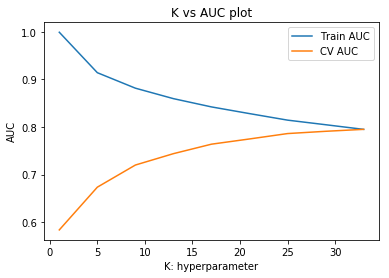

In [247]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,35,4))
for i in K:
    neigh_b = KNeighborsClassifier(n_neighbors=i)
    neigh_b.fit(trainb_text_feature_norm, Y1_train)
    
    Y_train_pred =  neigh_b.predict_proba(trainb_text_feature_norm)[:,1]
    Y_cv_pred =  neigh_b.predict_proba(cvb_text_feature_norm)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC plot")
plt.show()


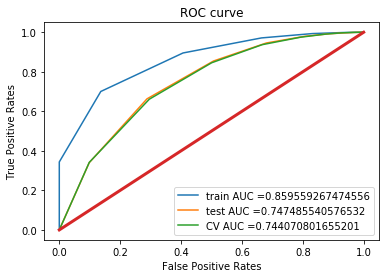

In [286]:
from sklearn.metrics import roc_curve, auc


knn_b = KNeighborsClassifier(n_neighbors=13)
knn_b.fit(trainb_text_feature_norm, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_b.predict_proba(trainb_text_feature_norm)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_b.predict_proba(testb_text_feature_norm)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,knn_b.predict_proba(cvb_text_feature_norm)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=3.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()


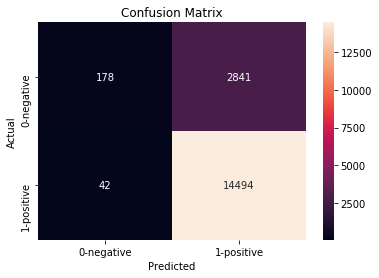

In [287]:
import seaborn as sb
C_b = confusion_matrix(Y1_test,knn_b.predict(testb_text_feature_norm))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



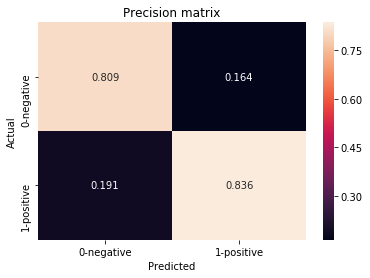

In [288]:
B_b =(C_b/C_b.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

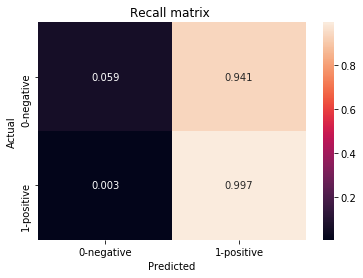

In [289]:
A_b =(((C_b.T)/(C_b.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [290]:
fpr, tpr, thresholds = metrics.roc_curve(Y1_test, knn_b.predict_proba(testb_text_feature_norm)[:,1])

In [291]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [292]:
evaluate_threshold(0.5)

Sensitivity: 0.9971106219042377
Specificity: 0.05895992050347798


In [293]:
evaluate_threshold(0.6)

Sensitivity: 0.9925013758943313
Specificity: 0.11129513083802589


In [294]:
evaluate_threshold(0.7)

Sensitivity: 0.9456521739130435
Specificity: 0.3196422656508777


In [298]:
y_pred_prob_b = knn_b.predict_proba(testb_text_feature_norm)[:, 1]   

In [299]:
r1=y_pred_prob_b.reshape(-1,1)

In [309]:
from sklearn.preprocessing import binarize
y_pred_class1 = binarize(r1, 0.7)

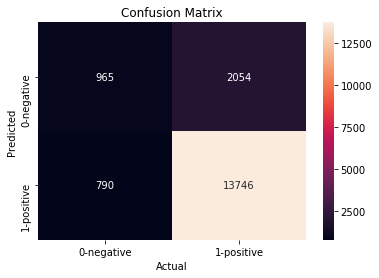

In [310]:
import seaborn as sb
C_b1 = confusion_matrix(Y1_test,y_pred_class1)
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


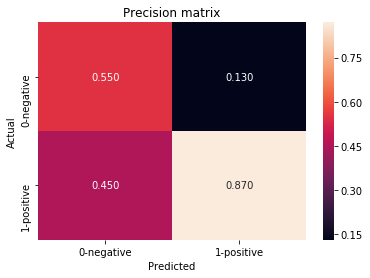

In [311]:
B_b1 =(C_b1/C_b1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


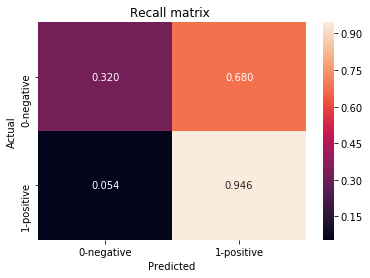

In [312]:
A_b1 =(((C_b1.T)/(C_b1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## USING NEW FEATURE LENGTH

In [313]:
from sklearn.preprocessing import Normalizer
normalizer_count=Normalizer()
normalizer_count.fit(X1_train["text_len"].values.reshape(-1,1))

Normalizer(copy=True, norm='l2')

In [314]:
train_count=normalizer_count.transform(X1_train["text_len"].values.reshape(-1,1))
cv_count=normalizer_count.transform(X1_cv["text_len"].values.reshape(-1,1))
test_count=normalizer_count.transform(X1_test["text_len"].values.reshape(-1,1))

In [315]:
train_count.shape

(56174, 1)

In [316]:
cv_count.shape

(14044, 1)

In [317]:
test_count.shape

(17555, 1)

In [318]:
from scipy.sparse import hstack
train_x_hstackb = hstack((trainb_text_feature_norm, train_count)).tocsr()
train_y_hstackb = np.array(list(Y1_train))

In [320]:
cv_x_hstackb = hstack((cvb_text_feature_norm, cv_count)).tocsr()
cv_y_hstackb = np.array(list(Y1_cv))


In [321]:
test_x_hstackb = hstack((testb_text_feature_norm,test_count )).tocsr()
test_y_hstackb = np.array(list(Y1_test))

In [322]:
print("(number of data points * number of features) in train data = ", train_x_hstackb.shape)
print("(number of data points * number of features) in test data = ", test_x_hstackb.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_hstackb.shape)


(number of data points * number of features) in train data =  (56174, 44052)
(number of data points * number of features) in test data =  (17555, 44052)
(number of data points * number of features) in cross validation data = (14044, 44052)


1 -----> 0.5839627131514014
5 -----> 0.673382046647937
9 -----> 0.7212165354684199
13 -----> 0.7458475644009785
17 -----> 0.7670486775081863
21 -----> 0.7803625347467384
25 -----> 0.7915049653548573
29 -----> 0.7986830882901512


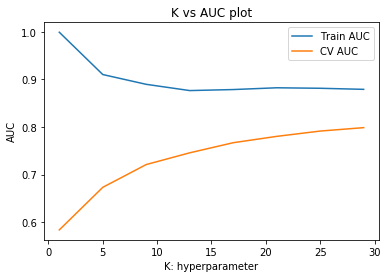

In [323]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc_t = []
cv_auc_t = []
K=list(range(1,31,4))
for i in K:
    neigh_b1 = KNeighborsClassifier(n_neighbors=i)
    neigh_b1.fit(train_x_hstackb, train_y_hstackb)
    
    Y_train_pred =  neigh_b1.predict_proba(train_x_hstackb)[:,1]
    Y_cv_pred =  neigh_b1.predict_proba(cv_x_hstackb)[:,1]
    train_auc_score=roc_auc_score(train_y_hstackb,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(cv_y_hstackb, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(K, train_auc_t, label='Train AUC')
plt.plot(K, cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC plot")
plt.show()

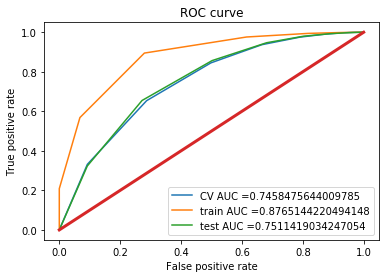

In [336]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_bow1 = KNeighborsClassifier(n_neighbors=13,algorithm="brute")
knn_bow1.fit(train_x_hstackb, train_y_hstackb)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(cv_y_hstackb,knn_bow1.predict_proba(cv_x_hstackb)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(train_y_hstackb, knn_bow1.predict_proba(train_x_hstackb)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(test_y_hstackb, knn_bow1.predict_proba(test_x_hstackb)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()


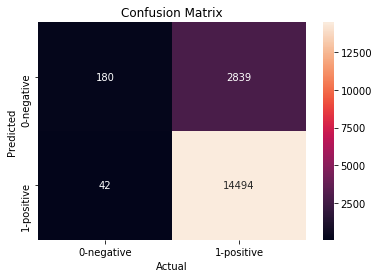

In [337]:
import seaborn as sb
C_bow = confusion_matrix(test_y_hstackb,knn_bow1.predict(test_x_hstackb))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


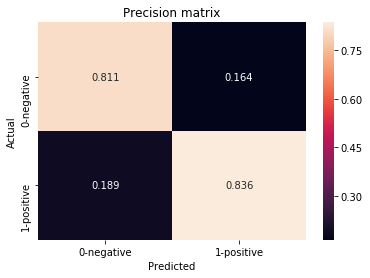

In [338]:
B_bow =(C_bow/C_bow.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


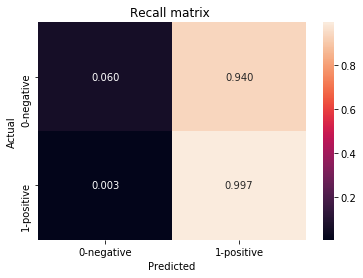

In [339]:
A_bow =(((C_bow.T)/(C_bow.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [340]:
fpr, tpr, thresholds = metrics.roc_curve(test_y_hstackb, knn_bow1.predict_proba(test_x_hstackb)[:,1])

In [341]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [342]:
evaluate_threshold(0.5)

Sensitivity: 0.9971106219042377
Specificity: 0.059622391520370965


In [343]:
evaluate_threshold(0.6)

Sensitivity: 0.9925013758943313
Specificity: 0.11096389532957929


In [344]:
evaluate_threshold(0.7)

Sensitivity: 0.9468216840946615
Specificity: 0.31897979463398474


In [345]:
y_pred_prob_b1 = knn_bow1.predict_proba(test_x_hstackb)[:, 1]  

In [346]:
r1=y_pred_prob_b1.reshape(-1,1)

In [351]:
from sklearn.preprocessing import binarize
y_pred_class2 = binarize(r1, 0.7)

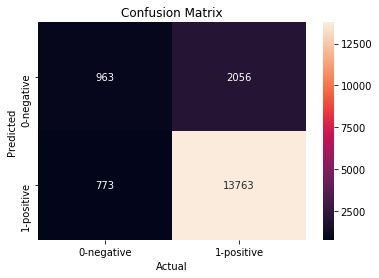

In [352]:
import seaborn as sb
C_bow1 = confusion_matrix(test_y_hstackb,y_pred_class2 )
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_bow1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

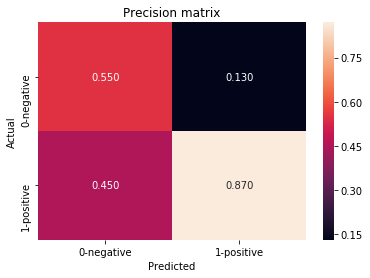

In [353]:
B_bow1 =(C_bow1/C_bow1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

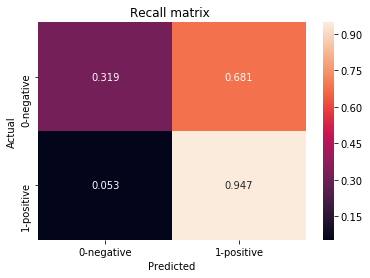

In [354]:
A_bow1 =(((C_bow1.T)/(C_bow1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_bow1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## KD Tree

In [355]:
count_vect = CountVectorizer(min_df=5, max_features=500)
X_train_BOW_kd = count_vect.fit_transform(X1_train["UPDATEDTEXT"])
X_train_BOW_kd.shape

(56174, 500)

In [356]:
X_cv_BOW_kd=count_vect.transform(X1_cv["UPDATEDTEXT"])
X_cv_BOW_kd.shape


(14044, 500)

In [357]:
X_test_BOW_kd= count_vect.transform(X1_test["UPDATEDTEXT"])
X_test_BOW_kd.shape

(17555, 500)

In [358]:
X_train_denBOW=X_train_BOW_kd.toarray()
X_cv_denBOW=X_cv_BOW_kd.toarray()
X_test_denBOW=X_test_BOW_kd.toarray()

In [359]:
from sklearn.preprocessing import normalize
trainb_text_feature_normkd = normalize(X_train_denBOW , axis=0)

cvb_text_feature_normkd=normalize(X_cv_denBOW,axis=0)

testb_text_feature_normkd=normalize(X_test_denBOW,axis=0)

1 -----> 0.6080813641516607
5 -----> 0.7062531851214493
9 -----> 0.735269959292106
13 -----> 0.7506582809696032
17 -----> 0.759521018312873
21 -----> 0.7661968778174342
25 -----> 0.7706273900918775
29 -----> 0.7749997034161306


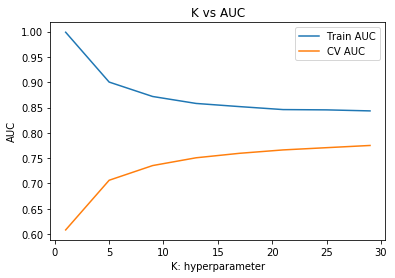

In [361]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,31,4))
for i in K:
    neigh_bowkd = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh_bowkd.fit(trainb_text_feature_normkd, Y1_train)
    
    Y_train_pred =  neigh_bowkd.predict_proba(trainb_text_feature_normkd)[:,1]
    Y_cv_pred =  neigh_bowkd.predict_proba(cvb_text_feature_normkd)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC")
plt.show()

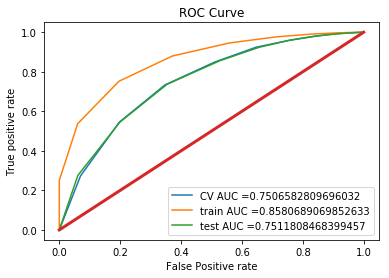

In [363]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_bow_kd = KNeighborsClassifier(n_neighbors=13,algorithm="kd_tree")
knn_bow_kd.fit(trainb_text_feature_normkd, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,knn_bow_kd.predict_proba(cvb_text_feature_normkd)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_bow_kd.predict_proba(trainb_text_feature_normkd)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_bow_kd.predict_proba(testb_text_feature_normkd)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()


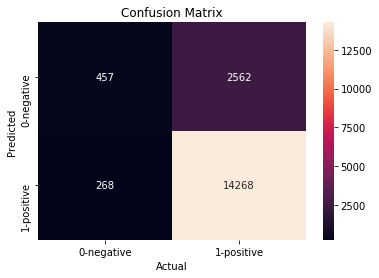

In [364]:
import seaborn as sb
C_t_bow = confusion_matrix(Y1_test,knn_bow_kd.predict(testb_text_feature_normkd))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

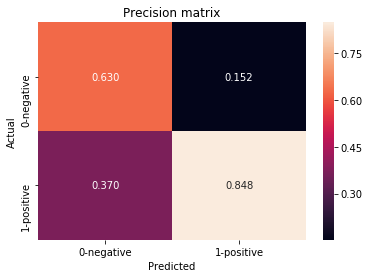

In [365]:

B_t_bow =(C_t_bow/C_t_bow.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_t_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


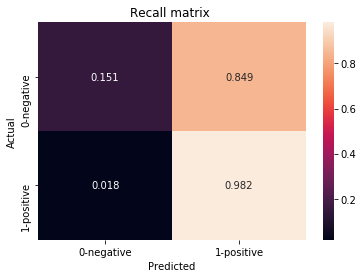

In [366]:
A_t_bow =(((C_t_bow.T)/(C_t_bow.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_t_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [368]:
y_pred_prob_bow = knn_bow_kd.predict_proba(testb_text_feature_normkd)[:, 1] 
fpr, tpr, thresholds = metrics.roc_curve(Y1_test,y_pred_prob_bow)


In [369]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])
    

In [370]:
    
evaluate_threshold(0.5) 

Sensitivity: 0.9815630159603742
Specificity: 0.15137462736005303


In [371]:
    
evaluate_threshold(0.6) 

Sensitivity: 0.9613373692900385
Specificity: 0.23848956608148397


In [372]:
    
evaluate_threshold(0.7) 

Sensitivity: 0.8560126582278481
Specificity: 0.47234183504471683


In [376]:
evaluate_threshold(0.8) 

Sensitivity: 0.7364474408365438
Specificity: 0.6462404769791321


In [373]:
r1=y_pred_prob_bow.reshape(-1,1)

In [385]:
from sklearn.preprocessing import binarize
y_pred_classbow = binarize(r1, 0.6)


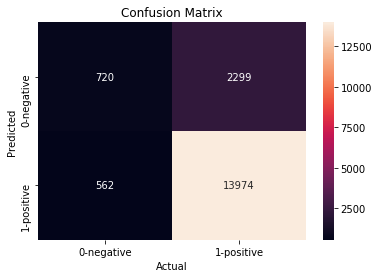

In [386]:
import seaborn as sb
C_bowkd = confusion_matrix(Y1_test,y_pred_classbow )
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_bowkd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

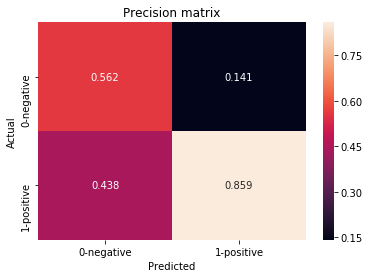

In [387]:
B_bowkd=(C_bowkd/C_bowkd.sum(axis=0))
df_conf_matrix = pd.DataFrame(
B_bowkd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

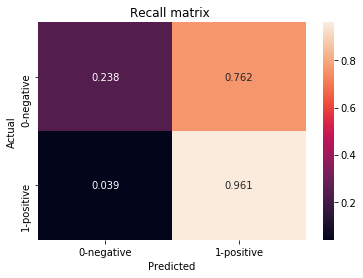

In [388]:
A_bowkd=(((C_bowkd.T)/(C_bowkd.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_bowkd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] We get Test AUC of 74.7 for BOW.<br>
2] For KD Tree implementation of BOW we get Test AUC of 75.11.<br>
3] If we add a new feature "length of text" we get Test AUC of 75.11.<br>
4] BOW performed pretty well on the data.    

## [2] TFIDF

In [49]:
tf_idf_vect = TfidfVectorizer(min_df = 5, ngram_range = (1,2))
tf_idf_vect.fit(X1_train["UPDATEDTEXT"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X1_train_tfidf = tf_idf_vect.transform(X1_train["UPDATEDTEXT"])
print("the type of count vectorizer ",type(X1_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X1_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X1_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal pain', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56174, 72828)
the number of unique words including both unigrams and bigrams  72828


In [50]:
X1_cv_tfidf=tf_idf_vect.transform(X1_cv["UPDATEDTEXT"])
X1_cv_tfidf.shape

(14044, 72828)

In [51]:
X1_test_tfidf=tf_idf_vect.transform(X1_test["UPDATEDTEXT"])
X1_test_tfidf.shape

(17555, 72828)

In [54]:
from sklearn.preprocessing import normalize
train_text_feature_norm = normalize(X1_train_tfidf , axis=0)

cv_text_feature_norm=normalize(X1_cv_tfidf,axis=0)

test_text_feature_norm=normalize(X1_test_tfidf,axis=0)


In [55]:
train_text_feature_norm.shape

(56174, 72828)

In [56]:
cv_text_feature_norm.shape

(14044, 72828)

In [57]:
test_text_feature_norm.shape

(17555, 72828)

1 -----> 0.5481882439635086
5 -----> 0.5554310924970628
9 -----> 0.5405244446588743
13 -----> 0.534221595712086
17 -----> 0.5291921462860542
21 -----> 0.5295574222249819
25 -----> 0.528312581296884
29 -----> 0.527359474325735


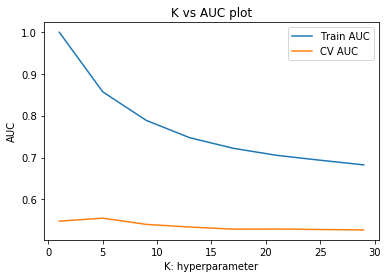

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc_t = []
cv_auc_t = []
K=list(range(1,31,4))
for i in K:
    neigh_t = KNeighborsClassifier(n_neighbors=i)
    neigh_t.fit(train_text_feature_norm, Y1_train)
    
    Y_train_pred =  neigh_t.predict_proba(train_text_feature_norm)[:,1]
    Y_cv_pred =  neigh_t.predict_proba(cv_text_feature_norm)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(K, train_auc_t, label='Train AUC')
plt.plot(K, cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC plot")
plt.show()

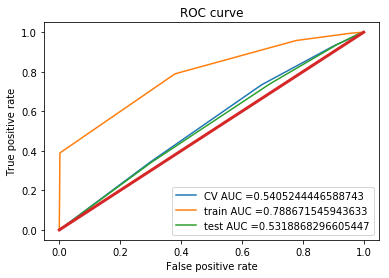

In [432]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_tfidf = KNeighborsClassifier(n_neighbors=9,algorithm="brute")
knn_tfidf.fit(train_text_feature_norm, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,knn_tfidf.predict_proba(cv_text_feature_norm)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_tfidf.predict_proba(train_text_feature_norm)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_tfidf.predict_proba(test_text_feature_norm)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

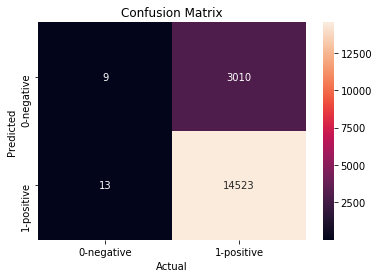

In [433]:
import seaborn as sb
C_t = confusion_matrix(Y1_test,knn_tfidf.predict(test_text_feature_norm))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

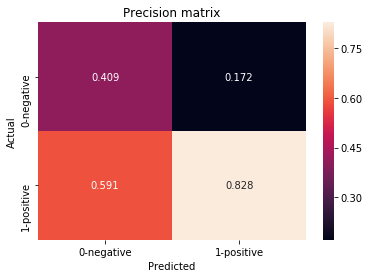

In [434]:
B =(C_t/C_t.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

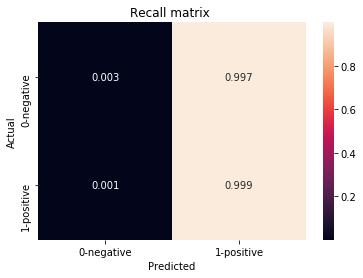

In [435]:
A =(((C_t.T)/(C_t.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [436]:
y_pred_prob_t = knn_tfidf.predict_proba(test_text_feature_norm)[:,1]


In [437]:
fpr, tpr, thresholds = metrics.roc_curve(Y1_test, y_pred_prob_t )

In [438]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [446]:
evaluate_threshold(0.6)

Sensitivity: 0.9905751238304898
Specificity: 0.01821795296455775


In [447]:
r1=y_pred_prob_t.reshape(-1,1)

In [460]:
from sklearn.preprocessing import binarize
y_pred_class1 = binarize(r1, 0.6)

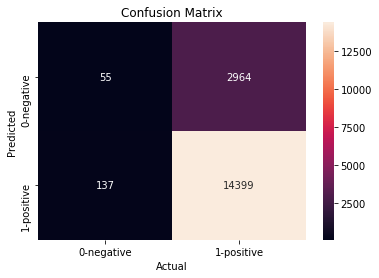

In [461]:
import seaborn as sb
C_t4 = confusion_matrix(test_y_hstack,y_pred_class1)
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t4, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

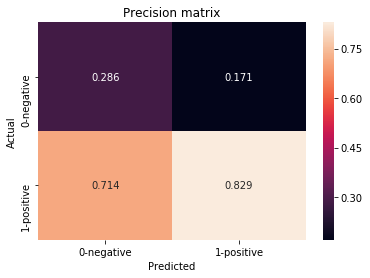

In [462]:
B4 =(C_t4/C_t4.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B4, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

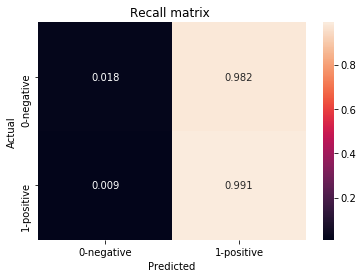

In [463]:
A4 =(((C_t4.T)/(C_t4.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A4, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Using new feature length

In [468]:
from sklearn.preprocessing import Normalizer
normalizer_count=Normalizer()
normalizer_count.fit(X1_train["text_len"].values.reshape(-1,1))

Normalizer(copy=True, norm='l2')

In [469]:
train_count=normalizer_count.transform(X1_train["text_len"].values.reshape(-1,1))
cv_count=normalizer_count.transform(X1_cv["text_len"].values.reshape(-1,1))
test_count=normalizer_count.transform(X1_test["text_len"].values.reshape(-1,1))

In [470]:
train_count.shape

(56174, 1)

In [471]:
cv_count.shape

(14044, 1)

In [472]:
test_count.shape

(17555, 1)

In [473]:
from scipy.sparse import hstack
train_x_hstack = hstack((train_text_feature_norm, train_count)).tocsr()
train_y_hstack = np.array(list(Y1_train))

In [474]:
cv_x_hstack = hstack((cv_text_feature_norm, cv_count)).tocsr()
cv_y_hstack = np.array(list(Y1_cv))

In [475]:
test_x_hstack = hstack((test_text_feature_norm,test_count )).tocsr()
test_y_hstack = np.array(list(Y1_test))

In [476]:
print("(number of data points * number of features) in train data = ", train_x_hstack.shape)
print("(number of data points * number of features) in test data = ", test_x_hstack.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_hstack.shape)

(number of data points * number of features) in train data =  (56174, 72829)
(number of data points * number of features) in test data =  (17555, 72829)
(number of data points * number of features) in cross validation data = (14044, 72829)


1 -----> 0.5763544985318468
5 -----> 0.5870593913074927
9 -----> 0.6062399659546959
13 -----> 0.6090945631615285
17 -----> 0.5934816130080638
21 -----> 0.5992193299555586
25 -----> 0.6330102029538743
29 -----> 0.6196369027355274


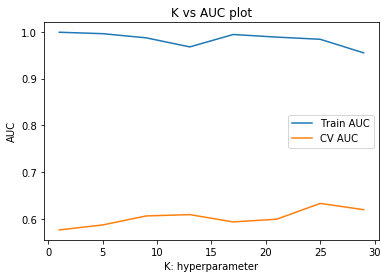

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc_t = []
cv_auc_t = []
K=list(range(1,31,4))
for i in K:
    neigh_t = KNeighborsClassifier(n_neighbors=i)
    neigh_t.fit(train_x_hstack, train_y_hstack)
    
    Y_train_pred =  neigh_t.predict_proba(train_x_hstack)[:,1]
    Y_cv_pred =  neigh_t.predict_proba(cv_x_hstack)[:,1]
    train_auc_score=roc_auc_score(train_y_hstack,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(cv_y_hstack, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(K, train_auc_t, label='Train AUC')
plt.plot(K, cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC plot")
plt.show()

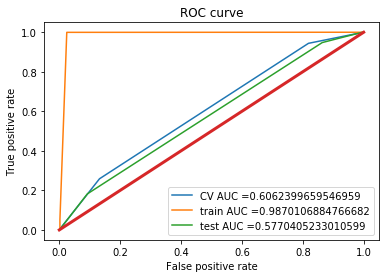

In [485]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_tfidf1 = KNeighborsClassifier(n_neighbors=9,algorithm="brute")
knn_tfidf1.fit(train_x_hstack, train_y_hstack)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(cv_y_hstack,knn_tfidf1.predict_proba(cv_x_hstack)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(train_y_hstack, knn_tfidf1.predict_proba(train_x_hstack)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(test_y_hstack, knn_tfidf1.predict_proba(test_x_hstack)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

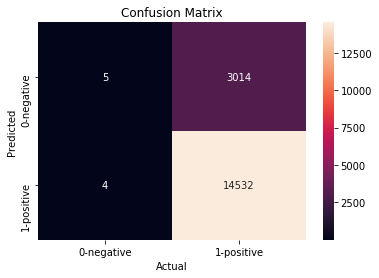

In [486]:
import seaborn as sb
C_t1 = confusion_matrix(test_y_hstack,knn_tfidf1.predict(test_x_hstack))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

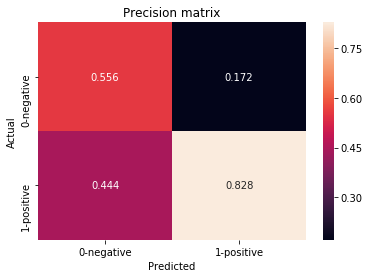

In [487]:
B =(C_t1/C_t1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

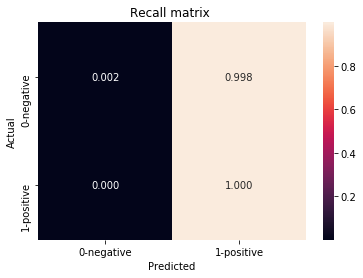

In [488]:
A =(((C_t1.T)/(C_t1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [489]:
y_pred_prob_t1 = knn_tfidf1.predict_proba(test_x_hstack)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(test_y_hstack, y_pred_prob_t1)

In [490]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [491]:
evaluate_threshold(0.5)

Sensitivity: 0.999724821133737
Specificity: 0.001656177542232573


In [492]:
evaluate_threshold(0.6)

Sensitivity: 0.9984177215189873
Specificity: 0.008280887711162643


In [493]:
evaluate_threshold(0.7)

Sensitivity: 0.9477160154100165
Specificity: 0.1361377939715137


In [494]:
evaluate_threshold(0.8)

Sensitivity: 0.18251238304898185
Specificity: 0.907585293143425


In [495]:
r=y_pred_prob_t1.reshape(-1,1)

In [496]:
from sklearn.preprocessing import binarize
y_pred_class = binarize(r, 0.7)

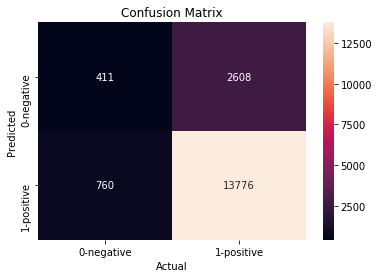

In [497]:
import seaborn as sb
C_t2 = confusion_matrix(test_y_hstack,y_pred_class)
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t2, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

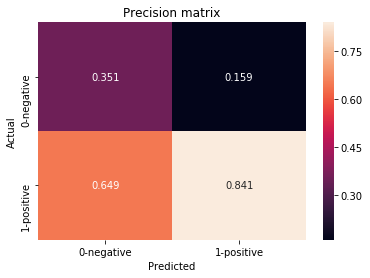

In [498]:
B2 =(C_t2/C_t2.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B2, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

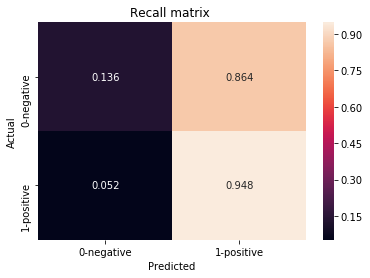

In [499]:
A2 =(((C_t2.T)/(C_t2.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A2, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## KD Tree

In [210]:
tf_idf_vect = TfidfVectorizer(min_df=5, max_features=500)
tf_idf_vect.fit(X1_train["UPDATEDTEXT"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf_kd = tf_idf_vect.transform(X1_train["UPDATEDTEXT"])
print("the type of count vectorizer ",type(X_train_tfidf_kd))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf_kd.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf_kd.get_shape()[1])

some sample features(unique words in the corpus) ['able', 'absolutely', 'actually', 'add', 'added', 'ago', 'almonds', 'almost', 'also', 'alternative']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56174, 500)
the number of unique words including both unigrams and bigrams  500


In [211]:
X_cv_tfidf_kd=tf_idf_vect.transform(X1_cv["UPDATEDTEXT"])
X_cv_tfidf_kd.shape

(14044, 500)

In [212]:
X_test_tfidf_kd=tf_idf_vect.transform(X1_test["UPDATEDTEXT"])
X_test_tfidf_kd.shape

(17555, 500)

In [213]:
X_train_dentfidf=X_train_tfidf_kd.toarray()
X_cv_dentfidf=X_cv_tfidf_kd.toarray()
X_test_dentfidf=X_test_tfidf_kd.toarray()


In [214]:
from sklearn.preprocessing import normalize
train_text_feature_norm_kd = normalize(X_train_dentfidf , axis=0)

cv_text_feature_norm_kd=normalize(X_cv_dentfidf,axis=0)

test_text_feature_norm_kd=normalize(X_test_dentfidf,axis=0)

In [215]:
train_text_feature_norm_kd.shape

(56174, 500)

In [216]:
cv_text_feature_norm_kd.shape

(14044, 500)

In [217]:
test_text_feature_norm_kd.shape

(17555, 500)

1 -----> 0.5905976639143323
5 -----> 0.6691604952882108
9 -----> 0.6924732134283512
13 -----> 0.7041833542420453
17 -----> 0.7175763606105034
21 -----> 0.7265878947121134
25 -----> 0.7310977544400228
29 -----> 0.7341129035834867


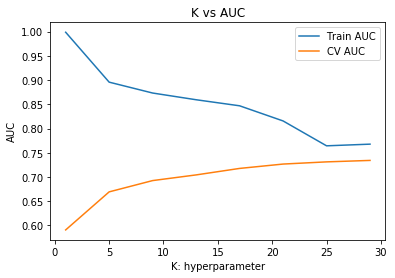

In [218]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,31,4))
for i in K:
    neigh_kd = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh_kd.fit(train_text_feature_norm_kd, Y1_train)
    
    Y_train_pred =  neigh_kd.predict_proba(train_text_feature_norm_kd)[:,1]
    Y_cv_pred =  neigh_kd.predict_proba(cv_text_feature_norm_kd)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC")
plt.show()

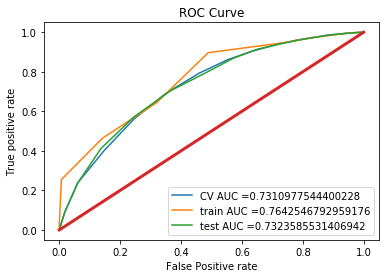

In [219]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_tfidf_kd = KNeighborsClassifier(n_neighbors=25,algorithm="kd_tree")
knn_tfidf_kd.fit(train_text_feature_norm_kd, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,knn_tfidf_kd.predict_proba(cv_text_feature_norm_kd)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_tfidf_kd.predict_proba(train_text_feature_norm_kd)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_tfidf_kd.predict_proba(test_text_feature_norm_kd)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve")
plt.show()

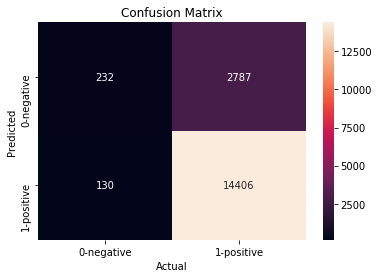

In [500]:
import seaborn as sb
C_t_kd = confusion_matrix(Y1_test,knn_tfidf_kd.predict(test_text_feature_norm_kd))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t_kd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

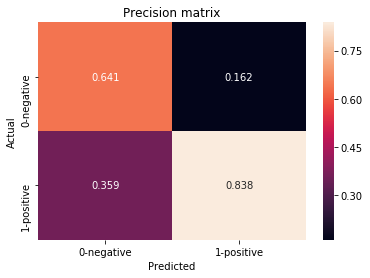

In [501]:
B_kd =(C_t_kd/C_t_kd.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_kd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

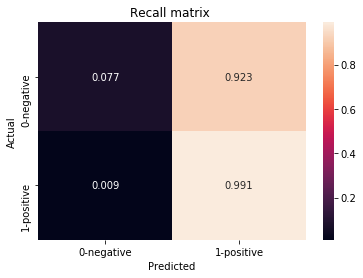

In [502]:
A_kd =(((C_t_kd.T)/(C_t_kd.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_kd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [504]:
y_pred_prob_t2 = knn_tfidf_kd.predict_proba(test_text_feature_norm_kd)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(Y1_test,y_pred_prob_t2)

In [505]:
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [507]:
evaluate_threshold(0.5)

Sensitivity: 0.9910566868464502
Specificity: 0.07684663795958924


In [508]:
evaluate_threshold(0.6)

Sensitivity: 0.9638827738029719
Specificity: 0.2003974826101358


In [509]:
evaluate_threshold(0.7)

Sensitivity: 0.9142817831590534
Specificity: 0.3487909903941703


In [510]:
r1=y_pred_prob_t2.reshape(-1,1)

In [513]:
from sklearn.preprocessing import binarize
y_pred_class_t = binarize(r1, 0.6)

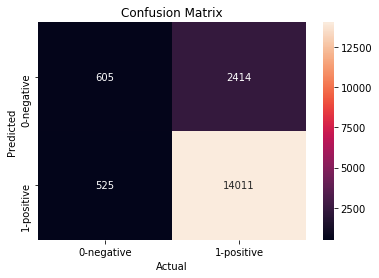

In [514]:
import seaborn as sb
C_t_ = confusion_matrix(Y1_test,y_pred_class_t)
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t_, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

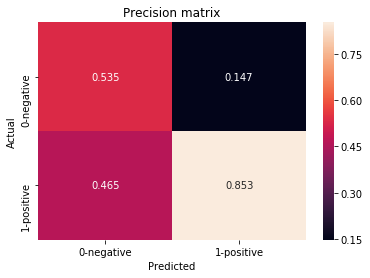

In [515]:
B_ =(C_t_/C_t_.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

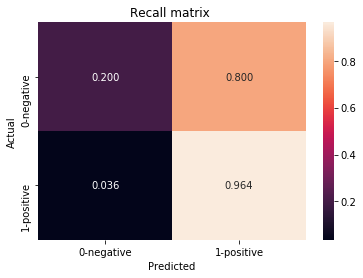

In [516]:
A_ =(((C_t_.T)/(C_t_.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] For Tfidf we get Test AUC of 53.18.<br>
2] For KD implementation of Tfidf the model performed well ,we got 73.2 as Test AUC.<br>
3] When we add new feature length the test AUC became 57.7.<br>

## [3] Average W2V

In [517]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X1_train["UPDATEDTEXT"]:
    list_of_sentance_train.append(sentance.split())

In [518]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_cv=[]
for sentance in X1_cv["UPDATEDTEXT"]:
    list_of_sentance_cv.append(sentance.split())

In [519]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_test=[]
for sentance in X1_test["UPDATEDTEXT"]:
    list_of_sentance_test.append(sentance.split())
    

In [520]:
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

        

[('awesome', 0.8343803286552429), ('fantastic', 0.8296641111373901), ('excellent', 0.8036624193191528), ('good', 0.7968162298202515), ('terrific', 0.7916436195373535), ('amazing', 0.7895281314849854), ('perfect', 0.7597982883453369), ('wonderful', 0.754323422908783), ('fabulous', 0.6822081804275513), ('decent', 0.6808624267578125)]
[('greatest', 0.7419604063034058), ('best', 0.732462465763092), ('tastiest', 0.6758474111557007), ('experienced', 0.6577657461166382), ('disgusting', 0.621694028377533), ('sweetest', 0.6019411087036133), ('smoothest', 0.5989356637001038), ('awful', 0.5984171628952026), ('superior', 0.5978534817695618), ('closest', 0.5943644642829895)]


In [521]:
        
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])


number of words that occured minimum 5 times  14127
sample words  ['dogs', 'loves', 'chicken', 'product', 'china', 'wont', 'buying', 'anymore', 'hard', 'find', 'products', 'made', 'usa', 'one', 'isnt', 'bad', 'good', 'take', 'chances', 'till', 'know', 'going', 'imports', 'love', 'saw', 'pet', 'store', 'tag', 'attached', 'regarding', 'satisfied', 'safe', 'infestation', 'literally', 'everywhere', 'flying', 'around', 'kitchen', 'bought', 'hoping', 'least', 'get', 'rid', 'weeks', 'fly', 'stuck', 'buggers', 'success', 'rate', 'day']


In [522]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|███████████████████████████████████████████████████████████████████████████| 56174/56174 [01:46<00:00, 526.95it/s]


56174
50


In [523]:

# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))



100%|███████████████████████████████████████████████████████████████████████████| 14044/14044 [00:24<00:00, 583.33it/s]


14044
50


In [524]:
# Please write all the code with proper documentation
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [00:34<00:00, 505.63it/s]


17555
50


1 -----> 0.6633244459137215
5 -----> 0.8092977979341824
9 -----> 0.8439820644826339
13 -----> 0.8592413135813163
17 -----> 0.8693314213499784
21 -----> 0.8734898517293399
25 -----> 0.8762110853566933
29 -----> 0.8777852876299213


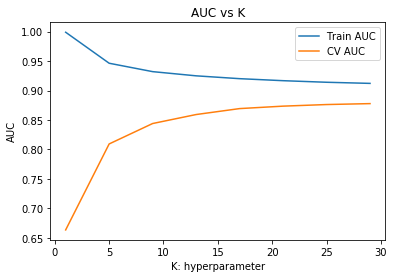

In [525]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,31,4))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
    neigh.fit(sent_vectors_train, Y1_train)
    
    Y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("AUC vs K")
plt.show()




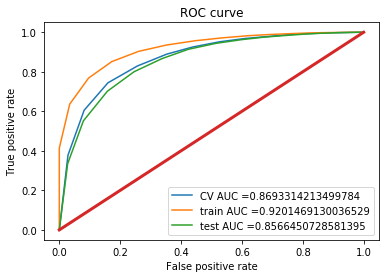

In [534]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_avg_w2v = KNeighborsClassifier(n_neighbors=17,algorithm="brute")
knn_avg_w2v.fit(sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,knn_avg_w2v.predict_proba(sent_vectors_cv)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_avg_w2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_avg_w2v.predict_proba(sent_vectors_test)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()



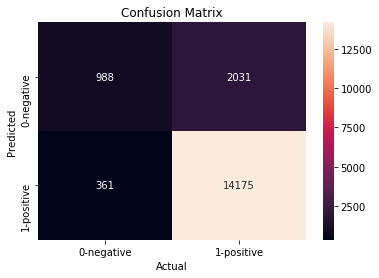

In [535]:
import seaborn as sb
C_a = confusion_matrix(Y1_test,knn_avg_w2v.predict(sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_a, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

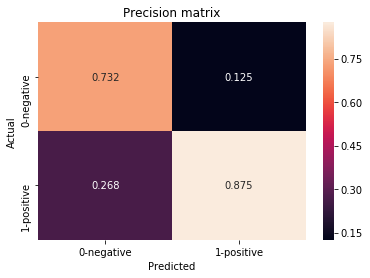

In [536]:
B_a =(C_a/C_a.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_a, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

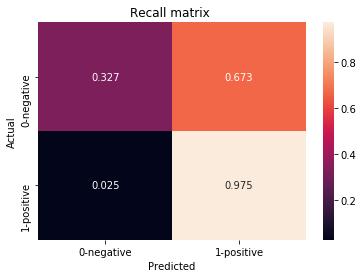

In [537]:
A =(((C_a.T)/(C_a.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## KD Tree

In [538]:
import scipy
scipy.sparse.issparse(sent_vectors_train)
scipy.sparse.issparse(sent_vectors_cv)
scipy.sparse.issparse(sent_vectors_test)

False

1 -----> 0.6633244459137215
5 -----> 0.8089758647078501
9 -----> 0.8436133629549403
13 -----> 0.8589292063859174
17 -----> 0.8691237765825238
21 -----> 0.8732741838724074
25 -----> 0.8759737281140485
29 -----> 0.8776371219010906


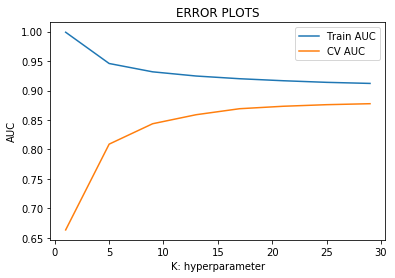

In [539]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,31,4))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(sent_vectors_train, Y1_train)
    
    Y_train_pred =  neigh.predict_proba(sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(sent_vectors_cv)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

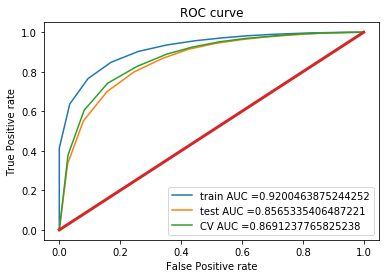

In [540]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_avg_w2v = KNeighborsClassifier(n_neighbors=17,algorithm="kd_tree")
knn_avg_w2v.fit(sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_avg_w2v.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_avg_w2v.predict_proba(sent_vectors_test)[:,1])
cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,knn_avg_w2v.predict_proba(sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.title("ROC curve")
plt.show()

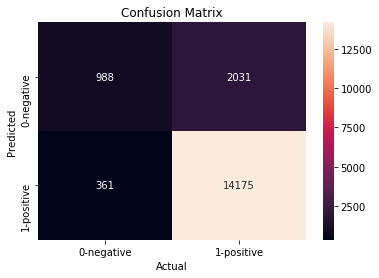

In [541]:
import seaborn as sb
cakd = confusion_matrix(Y1_test,knn_avg_w2v.predict(sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    cakd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

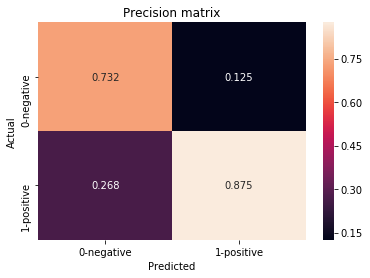

In [543]:
Bakd =(cakd/cakd.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    Bakd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

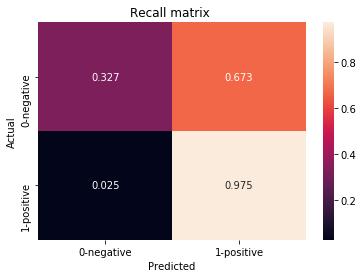

In [544]:
Aakd =(((cakd.T)/(cakd.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Aakd, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] We get Test AUC of 85.66 for Avg W2V.<br>
2] For KD Tree implementation of Avg A2V we get Test AUC of 86.9.<br>
3] Avg W2V performed the best amongst all the models.<br>

## [4] TFIDF weighted W2V

In [545]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X1_train["UPDATEDTEXT"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [546]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1  

100%|████████████████████████████████████████████████████████████████████████████| 56174/56174 [17:11<00:00, 54.45it/s]


In [547]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 14044/14044 [05:42<00:00, 41.05it/s]


In [548]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [13:30<00:00, 21.65it/s]


1 -----> 0.6510491370419045
5 -----> 0.7805278103899839
9 -----> 0.8131437064416106
13 -----> 0.8284199933370496
17 -----> 0.836171848302381
21 -----> 0.8421281899307956
25 -----> 0.8456628386253091
29 -----> 0.8476097088974331


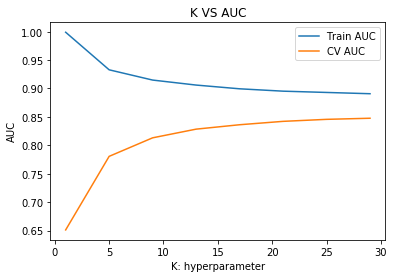

In [550]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,31,4))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="brute")
    neigh.fit(tfidf_sent_vectors_train, Y1_train)
    
    Y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K VS AUC")
plt.show()

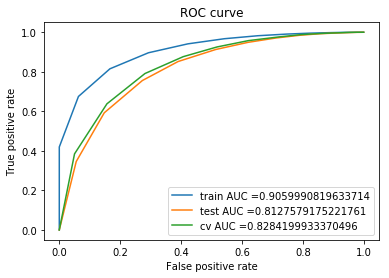

In [560]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_tfidfavg_w2v = KNeighborsClassifier(n_neighbors=13,algorithm="brute")
knn_tfidfavg_w2v.fit(tfidf_sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_tfidfavg_w2v.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_tfidfavg_w2v.predict_proba(tfidf_sent_vectors_test)[:,1])
cv_fpr, cv_tpr, thresholds = roc_curve(Y1_cv, knn_tfidfavg_w2v.predict_proba(tfidf_sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="cv AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

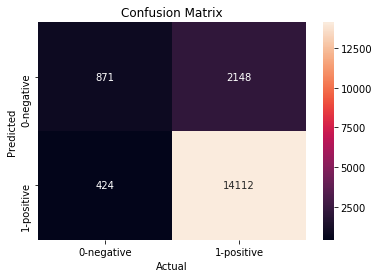

In [561]:
import seaborn as sb
cavg = confusion_matrix(Y1_test,knn_tfidfavg_w2v.predict(tfidf_sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    cavg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

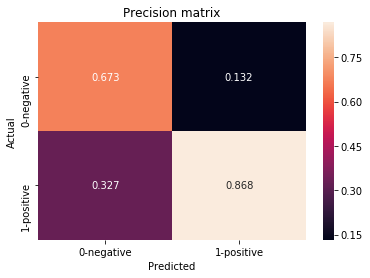

In [562]:
Bavg =(cavg/cavg.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    Bavg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

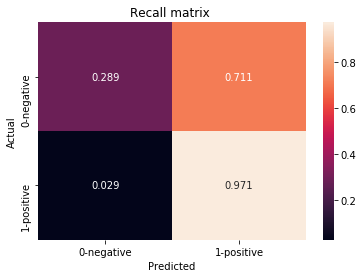

In [563]:
Aavg =(((cavg.T)/(cavg.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Aavg, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## KD Tree

In [564]:
import scipy
scipy.sparse.issparse(tfidf_sent_vectors_train)
scipy.sparse.issparse(tfidf_sent_vectors_cv)
scipy.sparse.issparse(tfidf_sent_vectors_test)

False

1 -----> 0.6510491370419045
5 -----> 0.7805278103899839
9 -----> 0.8131437064416106
13 -----> 0.828305903201732
17 -----> 0.8362699463469865
21 -----> 0.8422279106227112
25 -----> 0.8457703480243133
29 -----> 0.8476466691972754


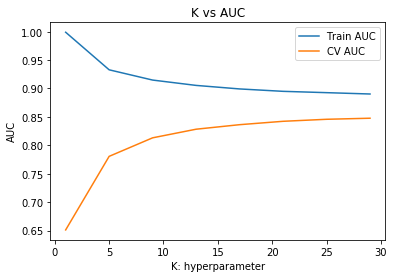

In [565]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
K=list(range(1,31,4))
for i in K:
    neigh = KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree")
    neigh.fit(tfidf_sent_vectors_train, Y1_train)
    
    Y_train_pred =  neigh.predict_proba(tfidf_sent_vectors_train)[:,1]
    Y_cv_pred =  neigh.predict_proba(tfidf_sent_vectors_cv)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i,"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)

plt.plot(K, train_auc, label='Train AUC')
plt.plot(K, cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("K vs AUC")
plt.show()

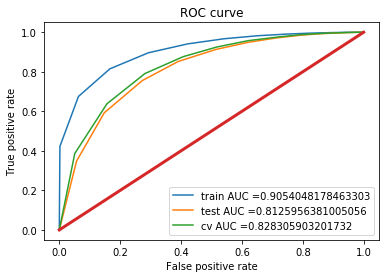

In [567]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


knn_tfidf_w2v_kd = KNeighborsClassifier(n_neighbors=13,algorithm="kd_tree")
knn_tfidf_w2v_kd.fit(tfidf_sent_vectors_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, knn_tfidf_w2v_kd.predict_proba(tfidf_sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, knn_tfidf_w2v_kd.predict_proba(tfidf_sent_vectors_test)[:,1])
cv_fpr, cv_tpr, thresholds = roc_curve(Y1_cv, knn_tfidf_w2v_kd.predict_proba(tfidf_sent_vectors_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="cv AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=3.0)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

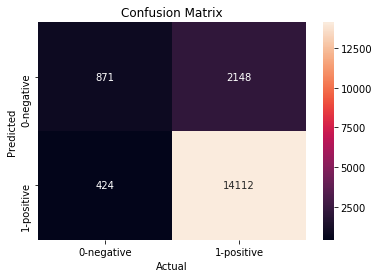

In [569]:
import seaborn as sb
ctwtv = confusion_matrix(Y1_test,knn_tfidf_w2v_kd.predict(tfidf_sent_vectors_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    ctwtv, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

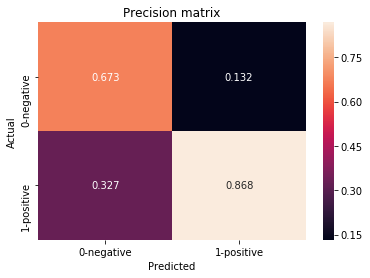

In [570]:
Btwtv =(ctwtv/ctwtv.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    Btwtv, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

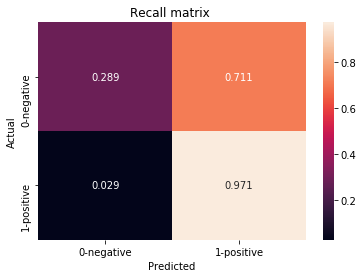

In [571]:
Atwtv =(((ctwtv.T)/(ctwtv.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    Atwtv, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Observations:<br>
1] We get Test AUC of 81.2 on Tfidf W2V models.<br>
2] For KD Tree implementation of of Tfidf W2V we get Test AUC of 81.2.<br>

## CONCLUSIONS:

In [583]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer", "Algorithm", "Best Hyperparameter","AUC score"])
x.align["Vectorizer"] = "l"
x.add_row(["BOW","BRUTE \n KD Tree \n Featurization \n ------------","13\n13\n13","74.7\n75.11\n75.11"])
x.add_row(["tfidf","BRUTE \n KD Tree \n Featurization \n ------------","9\n25\n9","53.18\n73.2\n57.7"])
x.add_row(["Average w2v","BRUTE \n KD Tree \n ------------","17\n17","85.66\n86.9"])
x.add_row(["Tfidf w2v","BRUTE \n KD Tree \n","13\n13","81.2\n81.2"])

print(x.get_string(title="KNN ON DIFFERENT FEATURIZATION"))

+-----------------------------------------------------------------+
|                  KNN ON DIFFERENT FEATURIZATION                 |
+-------------+-----------------+---------------------+-----------+
| Vectorizer  |    Algorithm    | Best Hyperparameter | AUC score |
+-------------+-----------------+---------------------+-----------+
| BOW         |      BRUTE      |          13         |    74.7   |
|             |     KD Tree     |          13         |   75.11   |
|             |  Featurization  |          13         |   75.11   |
|             |   ------------  |                     |           |
| tfidf       |      BRUTE      |          9          |   53.18   |
|             |     KD Tree     |          25         |    73.2   |
|             |  Featurization  |          9          |    57.7   |
|             |   ------------  |                     |           |
| Average w2v |      BRUTE      |          17         |   85.66   |
|             |     KD Tree     |          17   

1]  "Average w2v"  has the highest AUC score.<br>
3]  KD tree implementation of "Average W2V" performed the best <br>
4]  The kd-tree and brute implementation of KNN gives relatively similar results except for tfidf.<br>
5]  KNN performs fairly well on all featurizations except Tfidf.<br>
6]  It is very time consuming to have data with very high dimension. Very small subset were taken but still we are getting high     delay due to large dimension and time complexity of KNN.